# Cartpole Bayesian Sindy

The full cartpole equations are:

$$\ddot{x}=\frac{f-ml\ddot{\theta}\cos{\theta} +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x}}{m_c + m}$$

$$\ddot{\theta}=\frac{Mg\sin{\theta} -\cos{\theta}(f +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x})-\frac{M\mu_p\dot{\theta}}{ml}}{(1+k)Ml-ml\cos^2{\theta}}$$

In [2]:
using Turing, DifferentialEquations, StatsPlots, LinearAlgebra, Random

## Sim Data

In [3]:
function cartpole!(du, u, p, t)
    # u = [theta, theta_d, x, x_d]

    # external force
    # force = -0.2+0.5*sin(6*t)
    force = 0

    # Parameters
    m1, m2, gravity, length, mu_c, mu_p, k_inertia = p

    # theta_d
    du[1] = u[2]

    # theta_dd
    du[2] = ((m1+m2)*gravity*sin(u[1])-cos(u[1])*(force+m2*length*(u[2]^2)*sin(u[1])-mu_c*u[4])-((m1+m2)*mu_p*u[2])/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(cos(u[1]))^2)

    # x_d
    du[3] = u[4]

    # x_dd
    du[4] = (force-m2*length*(du[2]*cos(u[1])-(u[2]^2)*sin(u[1]))-mu_c*u[4]) / (m1+m2)
end

# Parameters 
# p = (1.0, 0.1, 9.8, 0.5, 0.05, 0.01, 1/3)
p = (1.5, 1.0, 9.8, 1.0, 0.05, 0.1, 1/3)

# Initial conditions
u0 = [0.524, 0.0, 0.0, 0.5]  # 30 degrees, 2 m/s to the right

tspan = (0.0,10.0)
probCart = ODEProblem(cartpole!,u0,tspan,p)

# Solve
sol = solve(probCart, Tsit5())

X = Array(sol)
t = sol.t
DX = Array(sol(sol.t,Val{1}))[[2], :]

plot(sol)


$$\ddot{x}=\frac{f-ml\ddot{\theta}\cos{\theta} +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x}}{m_c + m}$$

$$\ddot{\theta}=\frac{Mg\sin{\theta} -\cos{\theta}(f +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x})-\frac{M\mu_p\dot{\theta}}{ml}}{(1+k)Ml-ml\cos^2{\theta}}$$

### Generate dummy data for estimation

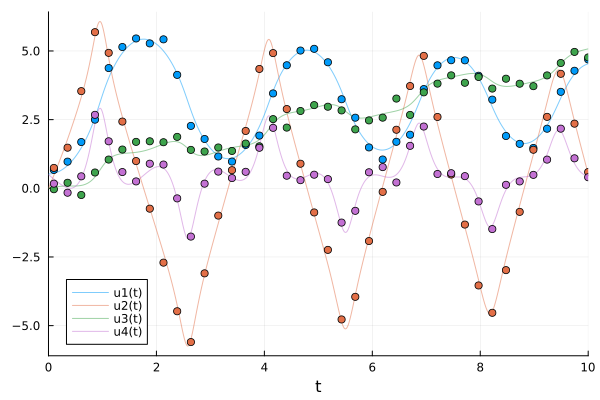

In [4]:
t = collect(range(0.1, stop=10, length=40))

odedata = Array(solve(probCart, saveat=t))
odedata = odedata + 0.2 * randn(size(odedata))
plot(sol; alpha=0.5)
scatter!(t, odedata'; color=[1 2 3 4], label="")


## Parameter Estimation

The cartpole system is more complicated than the pendulum for several reasons:

* 2 Equations to solve
* $\ddot{\theta}$ equation is super complex, can only roughly approximate

I'm especially interested to see how close $\ddot{\theta}$ can be approximated, and if the approximation holds up to a new starting configuration.

One of the hardest decisions is which set of basis functions to use?

* $\ddot{x}$ is a function of 4 variables: $\theta, \dot{\theta}, \ddot{\theta}, and \dot{x}$.
* $\ddot{\theta}$ is a function of 4 variables: $\theta, \dot{\theta}, and \dot{x}$.

I will start with 1st and 2nd powers and simple interactions of all terms, and use $sin(\theta)$ in place of $\theta$


In [5]:
#| output: false
function cartpoleSindy!(du, u, p, t)
    # u = [theta, theta_d, x, x_d]

    θ, θ̇, x, ẋ = u

    # theta_d and x_d
    du[1] = θ̇
    du[3] = ẋ

    # theta_dd
    θ̈ = (p[1]*sin(θ) +
         p[2]*cos(θ) + 
         p[3]*θ̇ + 
         p[4]*ẋ +
         p[5]*θ̇ *sin(θ)+ 
         p[6]*ẋ *sin(θ)+ 
         p[7]*ẋ *θ̇ + 
         p[8]*cos(θ) *sin(θ)+ 
         p[9]*ẋ *cos(θ)+ 
         p[10]*cos(θ) *θ̇ + 
         p[11]*cos(θ)^2+ 
         p[12]*sin(θ)^2+ 
         p[13]*θ̇ ^2+ 
         p[14]*ẋ^2+
         p[36])
    du[2] = θ̈ 

    # x_dd
    du[4] = (p[15]*sin(θ) +
             p[16]*cos(θ)+ 
             p[17]*θ̇ + 
             p[18]*θ̈  +
             p[19]*ẋ +
             p[20]*θ̇ *sin(θ)+ 
             p[21]*ẋ *sin(θ)+ 
             p[22]*ẋ *θ̇+ 
             p[23]*θ̈ *sin(θ)+ 
             p[24]*ẋ *θ̈ + 
             p[25]*θ̈  *θ̇+ 
             p[26]*ẋ *cos(θ)+ 
             p[27]*cos(θ) *θ̇+ 
             p[28]*cos(θ) *sin(θ)+ 
             p[29]*cos(θ) *θ̈ + 
             p[30]*sin(θ)^2+ 
             p[31]*cos(θ)^2+ 
             p[32]*θ̇ ^2+ 
             p[33]*θ̈  ^2+ 
             p[34]*ẋ^2 +
             p[35])
end

cartpoleProb = ODEProblem(cartpoleSindy!, u0, tspan, [0.0 for _ in 1:36])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 4-element Vector{Float64}:
 0.524
 0.0
 0.0
 0.5

In [8]:
#| output: false
@model function fitCartpoleLaplace(data, ::Type{T} = Float64) where {T <: Real}

    # Prior distributions
    se = [
        1.0,
        1.0,
        0.5,
        0.2,
        0.1,
        0.1, 
        0.1, 
        0.1, 
        0.1, 
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        1.0,
        1.0,
        0.2,
        0.2,
        0.2,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
    ]
    priors = [Laplace(0.0, se[i]) for i in 1:36]
    # priors = [Laplace(0.0, 0.1) for i in 1:36]
    theta = Vector{T}(undef, length(priors))
    syms = [Turing.@varname(theta[i]) for i in 1:length(priors)]
    for i in 1:length(priors)
        theta[i] ~ NamedDist(priors[i], syms[i])
    end

    σ ~ InverseGamma(2, 0.5)

    p = convert.(T, theta)
    u0 = convert.(T, cartpoleProb.u0)

    # Simulate model
    predicted = solve(cartpoleProb, Tsit5(); p=p, saveat=t)
    predicted_dense = solve(cartpoleProb, Tsit5(); p=p)
    failure = size(predicted, 2) < length(t)

    if failure
        Turing.@addlogprob! -Inf
        return
    end

    # Observations
    for i in 1:length(t)
        data[:, i] ~ MvNormal(predicted[:, i], σ^2 * I)
    end

    # return nothing
    return (; theta, predicted_dense)
end


fitCartpoleLaplace (generic function with 3 methods)

In [7]:
#| output: false
using Suppressor

modelHorse = fitCartpoleLaplace(odedata)
chain5 = 6
output = @capture_err chain5 = sample(modelHorse, NUTS(0.65; init_ϵ=0.01), MCMCSerial(), 500, 2; progress=true)
chain5

Chains MCMC chain (500×49×2 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 2
Samples per chain = 500
Wall duration     = 7308.98 seconds
Compute duration  = 7301.52 seconds
parameters        = theta[1], theta[2], theta[3], theta[4], theta[5], theta[6], theta[7], theta[8], theta[9], theta[10], theta[11], theta[12], theta[13], theta[14], theta[15], theta[16], theta[17], theta[18], theta[19], theta[20], theta[21], theta[22], theta[23], theta[24], theta[25], theta[26], theta[27], theta[28], theta[29], theta[30], theta[31], theta[32], theta[33], theta[34], theta[35], theta[36], σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

    the

In [18]:
#| output: false
# Save/read samples
path = "../Data/chain-cartpole-hs-hard-laplace-good.jls"
if @isdefined chain5
    write(path, chain5)
else
    chain5 = read(path, Chains)
end

In [9]:
#| output: false
using DataFramesMeta

finnish_chain = generated_quantities(modelHorse, MCMCChains.get_sections(chain5, :parameters))
finnish_df = reduce(vcat, DataFrame(finnish_chain[:, i]) for i in 1:size(finnish_chain, 2))


┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.0074051992061914. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.0074051992061914. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518


1000×2 DataFrame
  Row │ theta                              predicted_dense                   
      │ Array…                             ODESolution…                      
──────┼──────────────────────────────────────────────────────────────────────
    1 │ [6.18534, 5.08543, -0.291801, 1.…  ODESolution{Float64, 2, Vector{V…
    2 │ [6.12435, 5.08429, -0.293527, 0.…  ODESolution{Float64, 2, Vector{V…
    3 │ [6.12967, 5.08595, -0.29394, 0.9…  ODESolution{Float64, 2, Vector{V…
    4 │ [6.14175, 5.0823, -0.294333, 0.9…  ODESolution{Float64, 2, Vector{V…
    5 │ [6.21142, 5.07862, -0.293113, 0.…  ODESolution{Float64, 2, Vector{V…
    6 │ [6.15658, 5.07856, -0.297447, 1.…  ODESolution{Float64, 2, Vector{V…
    7 │ [6.0536, 5.07417, -0.298338, 0.9…  ODESolution{Float64, 2, Vector{V…
    8 │ [6.06088, 5.07287, -0.29734, 0.9…  ODESolution{Float64, 2, Vector{V…
  ⋮   │                 ⋮                                  ⋮
  994 │ [7.10008, 3.69333, -0.0591351, -…  ODESolution{Float64, 2, Vector{V…
  995 │ [7.10878, 3.68796, -0.0569061, -…  ODESolution{Float64, 2, Vector{V…
  996 │ [7.13287, 3.69075, -0.0588991, -…  ODESolution{Float64, 2, Vector{V…
  997 │ [7.1459, 3.69003, -0.0626188, -0…  ODESolution{Float64, 2, Vector{V…
  998 │ [7.16593, 3.6908, -0.0664793, -0…  ODESolution{Float64, 2, Vector{V…
  999 │ [7.17247, 3.70051, -0.066399, -0…  ODESolution{Float64, 2, Vector{V…
 1000 │ [7.18188, 3.69004, -0.0578488, -…  ODESolution{Float64, 2, Vector{V…
                                                             985 rows omitted

In [10]:
#| output: false
using DataFrames

# Extract coefficient samples

# Clean data from generated quantites
samples = size(finnish_chain, 1)
var_str = [
    "\$sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$cos(θ) \\rightarrow \\ddot{θ}\$",
    "\$\\dot{θ} \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} \\rightarrow \\ddot{θ}\$",
    "\$\\dot{θ} * sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} * sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{θ}\$",
    "\$cos(θ) * sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} * cos(θ) \\rightarrow \\ddot{θ}\$",
    "\$cos(θ) * \\dot{θ} \\rightarrow \\ddot{θ}\$",
    "\$cos(θ)^2 \\rightarrow \\ddot{θ}\$",
    "\$sin(θ)^2 \\rightarrow \\ddot{θ}\$",
    "\$\\dot{θ}^2 \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x}^2 \\rightarrow \\ddot{θ}\$",
    "\$sin(θ) \\rightarrow \\ddot{x}\$",
    "\$cos(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\ddot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} \\rightarrow \\ddot{x}\$",
    "\$\\dot{θ} * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\ddot{θ} * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * \\ddot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\ddot{θ} * \\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * cos(θ) \\rightarrow \\ddot{x}\$", #placeholder
    "\$cos(θ) * \\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$cos(θ) * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$cos(θ) * \\ddot{θ} \\rightarrow \\ddot{x}\$",
    "\$sin(θ)^2 \\rightarrow \\ddot{x}\$",
    "\$cos(θ)^2 \\rightarrow \\ddot{x}\$",
    "\$\\dot{θ}^2 \\rightarrow \\ddot{x}\$",
    "\$\\ddot{θ}^2 \\rightarrow \\ddot{x}\$",
    "\$\\dot{x}^2 \\rightarrow \\ddot{x}\$",
    "\$const \\rightarrow \\ddot{x}\$",
    "\$const \\rightarrow \\ddot{θ}\$",
]
beta1 = DataFrame([finnish_chain[i, 1][:theta] for i in 1:samples], :auto)
beta1[!,:var] = var_str
beta1[!,:chain] = [1 for _ in 1:size(beta1)[1]]
beta1 = DataFrames.stack(beta1, 1:samples)
beta2 = DataFrame([finnish_chain[i, 2][:theta] for i in 1:samples], :auto)
beta2[!,:var] = var_str
beta2[!,:chain] = [2 for _ in 1:size(beta2)[1]]
beta2 = DataFrames.stack(beta2, 1:samples)
beta = vcat(beta1, beta2)
beta

36000×4 DataFrame
   Row │ var                                chain  variable  value      
       │ String                             Int64  String    Float64    
───────┼────────────────────────────────────────────────────────────────
     1 │ $sin(θ) \\rightarrow \\ddot{θ}$        1  x1         6.18534
     2 │ $cos(θ) \\rightarrow \\ddot{θ}$        1  x1         5.08543
     3 │ $\\dot{θ} \\rightarrow \\ddot{θ}$      1  x1        -0.291801
     4 │ $\\dot{x} \\rightarrow \\ddot{θ}$      1  x1         1.00049
     5 │ $\\dot{θ} * sin(θ) \\rightarrow …      1  x1        -0.0100114
     6 │ $\\dot{x} * sin(θ) \\rightarrow …      1  x1         0.566889
     7 │ $\\dot{x} * \\dot{θ} \\rightarro…      1  x1        -0.126762
     8 │ $cos(θ) * sin(θ) \\rightarrow \\…      1  x1        -0.171927
   ⋮   │                 ⋮                    ⋮       ⋮          ⋮
 35994 │ $sin(θ)^2 \\rightarrow \\ddot{x}$      2  x500      -0.199124
 35995 │ $cos(θ)^2 \\rightarrow \\ddot{x}$      2  x500      -0.0148294
 35996 │ $\\dot{θ}^2 \\rightarrow \\ddot{…      2  x500       0.0306069
 35997 │ $\\ddot{θ}^2 \\rightarrow \\ddot…      2  x500      -0.0185031
 35998 │ $\\dot{x}^2 \\rightarrow \\ddot{…      2  x500       0.0879157
 35999 │ $const \\rightarrow \\ddot{x}$         2  x500       0.0127251
 36000 │ $const \\rightarrow \\ddot{θ}$         2  x500      -0.0419633
                                                      35985 rows omitted

In [17]:
#| output: false
gd = groupby(beta, [:var, :chain])
show(combine(gd, :value => mean), allrows=true)

72×3 DataFrame
 Row │ var                                chain  value_mean  
     │ String                             Int64  Float64     
─────┼───────────────────────────────────────────────────────
   1 │ $sin(θ) \\rightarrow \\ddot{θ}$        1   6.21457
   2 │ $cos(θ) \\rightarrow \\ddot{θ}$        1   5.10283
   3 │ $\\dot{θ} \\rightarrow \\ddot{θ}$      1  -0.313871
   4 │ $\\dot{x} \\rightarrow \\ddot{θ}$      1   1.14187
   5 │ $\\dot{θ} * sin(θ) \\rightarrow …      1  -0.0912968
   6 │ $\\dot{x} * sin(θ) \\rightarrow …      1   0.539513
   7 │ $\\dot{x} * \\dot{θ} \\rightarro…      1  -0.10839
   8 │ $cos(θ) * sin(θ) \\rightarrow \\…      1  -0.326944
   9 │ $\\dot{x} * cos(θ) \\rightarrow …      1  -0.200046
  10 │ $cos(θ) * \\dot{θ} \\rightarrow …      1  -0.0495677
  11 │ $cos(θ)^2 \\rightarrow \\ddot{θ}$      1  -0.218758
  12 │ $sin(θ)^2 \\rightarrow \\ddot{θ}$      1   0.0669556
  13 │ $\\dot{θ}^2 \\rightarrow \\ddot{…      1   0.0787503
  14 │ $\\dot{x}^2 \\rightarrow 

Estimated solved DE from additive equations:

#### $\ddot{\theta}$ Estimated DEs:

##### Chain 1

$
\ddot{\theta} = 6.2\sin{\theta}+5.1\cos{\theta} -0.31\dot{\theta} + 1.14\dot{x} + 0.54\dot{x}\sin{\theta} -0.32\cos{\theta}\sin{\theta}
$

##### Chain 2

$
\ddot{\theta} = 7.0\sin{\theta}+3.76\cos{\theta} + 0.56\dot{x}\sin{\theta}+ 0.28\dot{x}\sin{\theta} -1.09\cos{\theta}^2
$

#### $\ddot{x}$ Estimated DEs:

##### Chain 1

$
\ddot{x} = 1.75\sin{\theta}+0.79\cos{\theta} - 0.64\dot{x} + 0.3\ddot{\theta}\sin{\theta} -0.23\sin{\theta}^2
$

##### Chain 2

$
\ddot{x} = 1.61\sin{\theta}+0.42\cos{\theta} - 0.23\dot{x}\cos{\theta} -0.3\dot{x}^2
$

With the parameters used, the actual DEs are roughly:




$$
\ddot{\theta}=\frac{24.5\sin{\theta} -1.0\cos{\theta}\dot{\theta}^2\sin{\theta}+0.05\dot{x}\cos{\theta}-0.25\dot{\theta}}{3.33-1.0\cos^2{\theta}}\approx7.37\sin{\theta}-0.3cos{\theta}\dot{\theta}^2\sin{\theta}
$$

$$\ddot{x}=\frac{-1.0\ddot{\theta}\cos{\theta} +1.0\dot{\theta}^2\sin{\theta}-0.05\dot{x}}{2.5}\approx-0.4\ddot{\theta}\cos{\theta} +0.4\dot{\theta}^2\sin{\theta}$$


In [19]:
#| output: false
#| echo: false
gdf = groupby(beta, :var)
plot_list = []
for ((k,), v) in pairs(gdf)
    push!(plot_list, @df v density(:value, group=(:chain), title=k))
end

plot(plot_list..., layout=(length(plot_list), 1), size=(400, 200 * length(plot_list)), link = :x)
    


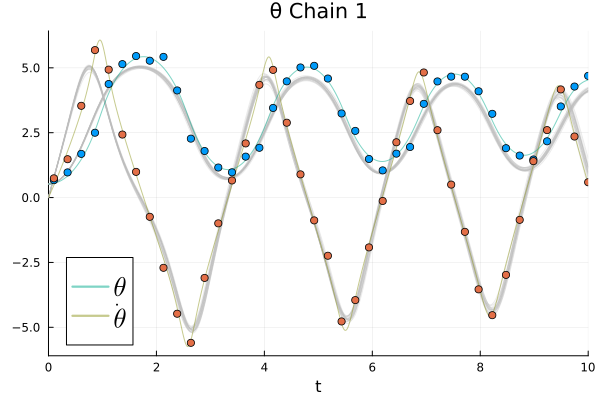

In [13]:
#| output: false
#| echo: false
plot(; title="θ Chain 1", legendfontsize=18)
all_sol = finnish_df.predicted_dense
for i in 1:25:500
    plot!(all_sol[i], idxs=[1, 2]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[1, 2]; alpha=0.5, linewidth=1, legend=true, label=["\$\\theta\$" "\$\\dot{\\theta}\$"])
scatter!(t, odedata[1:2, :]'; color=[1 2], label="")


In [14]:
#| output: false
#| echo: false
plot(; title="θ Chain 2", legendfontsize=18)
all_sol = finnish_df.predicted_dense
for i in 501:25:1000
    plot!(all_sol[i], idxs=[1, 2]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[1, 2]; alpha=0.5, linewidth=1, legend=true, label=["\$\\theta\$" "\$\\dot{\\theta}\$"])
scatter!(t, odedata[1:2, :]'; color=[1 2], label="")


In [15]:
#| output: false
#| echo: false
plot(; title="x Chain 1", legendfontsize=18)
all_sol = finnish_df.predicted_dense
# for i in 1:size(finnish_df, 1)
for i in 1:25:500
    plot!(all_sol[i], idxs=[3, 4]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[3, 4]; alpha=0.5, linewidth=1, label=["\$x\$" "\$\\dot{x}\$"])
scatter!(t, odedata[3:4, :]'; color=[1 2], label="")


In [16]:
#| output: false
#| echo: false

plot(; title="x Chain 2", legendfontsize=18)
all_sol = finnish_df.predicted_dense
# for i in 1:size(finnish_df, 1)
for i in 501:25:1000
    plot!(all_sol[i], idxs=[3, 4]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[3, 4]; alpha=0.5, linewidth=1, label=["\$x\$" "\$\\dot{x}\$"])
scatter!(t, odedata[3:4, :]'; color=[1 2], label="")


## Summary

The chains found slightly different solutions; both were pretty bad. They pick up on the general trends in x, but aren't able to do so with $\theta$